#**Problem Statement:**

## Overview
Welcome to the takehome assignment!
## Instructions
You've been given a short jupyter notebook that trains and evaluates a couple of models on a simple classification task.   
There are two parts to this assignment: Coding & Brainstorming.
#### Coding
The notebook is full of issues, ranging from general poor coding & ML practices to silent bugs. We'd like you to clean up the notebook and fix those issues.    
You can just focus on the models provided, there's no need to train any others. Though feel free to experiment if you'd like!  
#### Brainstorming
Based on the classification task description and notebook, think about: what are the pros and cons of the data labeling strategy that we're using and how does it affect other components of the classification pipeline? (We're using an LLM to create labels - see the bottom section for details).
There are many components to that answer - don't worry about covering everything. Instead, focus more in detail on a specific concept or two, and we'll discuss it at one of your next interviews!

## Files:
* `data.csv`: data for the task
* `train_models.ipynb`: notebook that trains the models
* `train_embs.npy`, `test_embs.npy`: Text embeddings for the data from `sentence-transformers/paraphrase-mpnet-base-v2`. Feel free to use these embeddings directly as in the notebook. The code to generate them is in the notebook, so you can recreate them if you'd like.


## Classification Task
This problem is a binary text classification problem. The messages being classified are social recognition messages which are supposed to be all about recognition & gratitude. Feel free to peruse examples in the notebook.  

The classification task is to determine whether a message is related "safety or security", and messages that are positively labeled should be related. Here are a couple of positive examples (they're also in the dataset):
* `Mary went above and beyond her own personal comfort zone in assisting in a safety incident in the lab. She printed MS sheets and made the situation safe for both me and her colleagues in the area. She also was an amazing, calming influence on a high stress situation.`
* `Lisa - thanks for taking the time to double check a suspicious contact that came in to you this week - although we were able to verify the message after a bit of digging it was certainly VERY odd looking and certainly worth a second look. You demonstrated fantastic security reflexes !`


However, our annotators were busy working on other projects, so these messages were not human labeled. Instead, they're labeled by an LLM with the following prompt:  
```
You will be given a piece of recognition or gratitude message written between colleagues at workplace.
You will determine whether or not that message is related to safety or security based solely on its content. Return "True" if it is related, and "False" otherwise.
```
The column `target` in the dataset, which is what the models in the notebook predict, is the LLM's output - True or False.

# Data Challenge Presentation

## Agenda
- [Observations/Issues](#observationsissues)
  - [Pre-processing Steps](#pre-processing-steps)
  - [Imbalance Target](#imbalance-target-sampling-techniques)
  - [Embedding Step](#embedding-step)
  - [Modelling](#modelling)
    - [Logistic Regression](#logistic-regression)
      - [Metric Choice](#metric-choice)
      - [Evaluation Process](#evaluation-process)
      - [Hyperparameter Tuning](#hyperparameter-tuning)
    - [XGBoost](#xgboost)
      - [Model Choice](#model-choice)
      - [Evaluation Process](#evaluation-process-1)
      - [Metric Selection](#metric-selection)
- [Conclusion](#conclusion)
  - [LLM Mis-labelling Impact](#llm-mis-labelling-impact)
  - [Handling LLM Bias](#handling-llm-bias)
- [Brainstorming](#brainstorming)
  - [Prompt Optimizatin](#prompt-optimization)

## Observations/Issues
<a id="observationsissues"></a>

### Pre-processing Steps
- **Current**: No preprocessing steps; modeling was implemented without these steps.
- **Proposed**: Implemented necessary preprocessing steps to clean and prepare the data.

### Imbalance Target: Sampling Techniques
<a id="imbalance-target"></a>
- **Current**: The current sampling strategy introduces several problems:
  - Duplicate samples.
  - Duplicating lower samples introduces a lot of noise and can cause overfitting.
  - Duplicating the majority class leads to losing some information.
  - Artificially introducing duplicates does not change the true distribution and class imbalance of the population, leading to poor generalization and poor results on the unseen validation set.
  - One of the pre-processing steps should be removing duplicates, but duplicates are introduced here.
- **Proposed**: SMOTE (Synthetic Minority Over-sampling Technique)

### Embedding Step
<a id="embedding-step"></a>
- **Current**: Embeddings are created after sampling.
- **Proposed**: Create embeddings before sampling to maintain data integrity and avoid noise.

### Modelling
<a id="modelling"></a>

#### Logistic Regression
<a id="logistic-regression"></a>
##### Metric Choice
<a id="metric-choice"></a>
- **Current**: Accuracy is used as the primary metric.
- **Proposed**: Use ROC AUC as the primary metric because accuracy is not a good choice for imbalanced datasets; it doesn't reflect performance on the minority class effectively.

##### Evaluation Process
<a id="evaluation-process"></a>
- **Current**: No cross validation is implemented.
- **Proposed**: Ensure robust validation through techniques like stratified K-fold cross-validation.

#### XGBoost
<a id="xgboost"></a>
##### Model Choice
<a id="model-choice"></a>
- **Current**: XGBRegressor is used, which is not suitable for classification problems.
- **Proposed**: Use XGBClassifier, which is designed for classification tasks.

##### Evaluation Process
<a id="evaluation-process"></a>
- **Current**: No cross validation is implemented.
- **Proposed**: Ensure robust validation through techniques like stratified K-fold cross-validation.

##### Metric Selection
<a id="metric-selection"></a>
- **Current**: Accuracy is the primary metric.
- **Proposed**: Focus on ROC AUC as it better represents model performance on both classes in an imbalanced dataset. Adjust the decision threshold based on the ROC AUC curve to balance precision and recall.

##### Hyperparameter Tuning
<a id="hyperparameter-tuning"></a>
- **Proposed**: Conduct hyperparameter tuning to avoid overfitting and ensure optimal model performance.

## Conclusion
<a id="conclusion"></a>

## Prompt Optimization
<a id="prompt-optimization"></a>



In [58]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

%cd /content/drive/MyDrive/Colab\ Notebooks/TextClassifier-NLP/
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/TextClassifier-NLP
/content/drive/MyDrive/Colab Notebooks/TextClassifier-NLP


In [59]:
#!pip install sentence-transformers
#from sentence_transformers import SentenceTransformer
#!pip install joblib

In [60]:
# import requried packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas(leave=False)

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK data files
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_fscore_support, roc_curve, auc

import xgboost as xgb
from imblearn.pipeline import Pipeline

import joblib
from joblib import dump, load
# Assuming grid_search is your GridSearchCV instance

import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


##**Load Data**

In [61]:
# setting random seed

seed = 42
np.random.seed(seed)
#random.seed(seed)

In [62]:
# loading data

df = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/TextClassifier-NLP/data.csv")
df.sample(10)

,text,target
677,Thankyou for helping read the results for the ...,False
1591,Congratulations on your remarkable achievement...,False
984,This is in recognition of the amazing job you ...,False
607,"Allison, I want to thank and recognize for all...",False
1392,"John, I want to thank you for the incredible ...",False
1033,"Guys ,everyone showed their metal today in exc...",False
1583,Your kindness does not go unnoticed and I want...,False
1309,"Margarita, I couldn't think of a better exampl...",False
1628,Thanks so much for all of the support as of la...,False
271,Congratulations on your recent work anniversar...,False


In [63]:
# check shape of data
df.shape, df['text'].nunique()

((1638, 2), 1638)

In [64]:
df['target'] = df['target'].map({False: 0, True: 1})

In [65]:
df["target"].value_counts()

target
0    1393
1     245
Name: count, dtype: int64

**Observations:**

*   Based on the observations so far, there is unbalance in the target variables.
* Current step: Sampling techniques
  * upsampling minor class to match major class
  * Issues with this process: duplicating both major and minor classes which is not a good sampling strategy as it causes various problems including overfitting by introducing noise, since major classes are also duplicated there is also loss of information, thereby not generalizing the model thus resulting in poor performance on unseen data
* Proposed changes:
  * Perform data cleaning
  * Use different sampling techniques



##**Data Preprocessing**

**Step 1: Tokenization**

In [66]:
def clean_text(text):
    # Remove unwanted characters (punctuation, numbers, special characters)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Convert text to lowercase
    text = text.lower()

    # Tokenization
    words = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatization with POS tagging
    lemmatizer = WordNetLemmatizer()
    pos_tags = pos_tag(words)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]

    # Rejoin words into a single string
    text = ' '.join(lemmatized_words)

    return text

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a'  # adjective
    elif tag.startswith('V'):
        return 'v'  # verb
    elif tag.startswith('N'):
        return 'n'  # noun
    elif tag.startswith('R'):
        return 'r'  # adverb
    else:
        return 'n'  # default to noun for lemmatization

In [67]:
# Apply the clean on df

df ['clean_text'] = df['text'].apply(clean_text)

In [68]:
# check for any missing values

print(df.isnull().sum())

print(df[['text', 'clean_text']].head())

text          0
target        0
clean_text    0
dtype: int64
                                                text  \
0  Thank you for quickly producing high quality p...   
1  Thank you for working safely and thank you for...   
2  Well done! Finding a potential trip hazard and...   
3  Thank you for the leadership you continue to p...   
4  Rakesh Lakshmanan worked closely with Cisco & ...   

                                          clean_text  
0  thank quickly produce high quality part smart ...  
1  thank work safely thank complete pit preinspec...  
2  well do find potential trip hazard come soluti...  
3  thank leadership continue provide ensure hazar...  
4  rakesh lakshmanan work closely cisco aruba ven...  


In [69]:
df.head()

,text,target,clean_text
0,Thank you for quickly producing high quality p...,1,thank quickly produce high quality part smart ...
1,Thank you for working safely and thank you for...,1,thank work safely thank complete pit preinspec...
2,Well done! Finding a potential trip hazard and...,1,well do find potential trip hazard come soluti...
3,Thank you for the leadership you continue to p...,1,thank leadership continue provide ensure hazar...
4,Rakesh Lakshmanan worked closely with Cisco & ...,1,rakesh lakshmanan work closely cisco aruba ven...


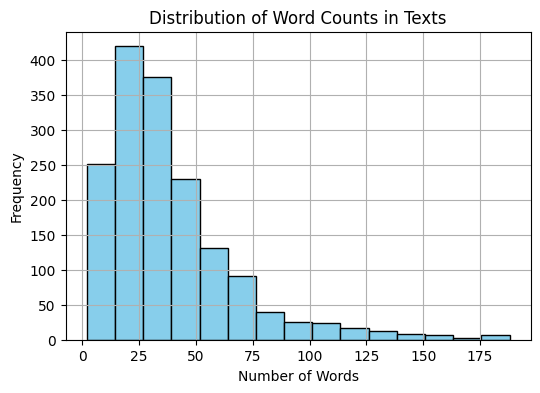

In [70]:
# Function to calculate number of words
def count_words(text):
    return len(text.split())

# Add new column for word count
df['word_count'] = df['clean_text'].apply(count_words)

# Visualize word count distribution as a histogram
plt.figure(figsize=(6, 4))
plt.hist(df['word_count'], bins=15, color='skyblue', edgecolor='black')
plt.title('Distribution of Word Counts in Texts')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [71]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
target,1638.0,0.149573,0.356761,0.0,0.0,0.0,0.0,1.0
word_count,1638.0,38.528694,29.098343,2.0,19.0,32.0,49.0,188.0


In [72]:
# Define upper and lower cutoffs based on descriptive statistics
lower_cutoff = 15  # Example lower cutoff
upper_cutoff = 50  # Example upper cutoff

# Apply lower and upper cutoffs
df = df[(df['word_count'] >= lower_cutoff) & (df['word_count'] <= upper_cutoff)]

# Optionally, truncate texts to upper cutoff length
df['truncated_text'] = df['clean_text'].apply(lambda x: ' '.join(x.split()[:upper_cutoff]))

In [73]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
target,1005.0,0.183085,0.386928,0.0,0.0,0.0,0.0,1.0
word_count,1005.0,30.234826,9.812819,15.0,22.0,29.0,38.0,50.0


**Step 2: Train test validation split**

In [74]:
X = df['truncated_text']
y = df['target']

In [75]:
# Initial split into train and validate
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Secondary split train into new train and test
#X_train_new, X_test, y_train_new, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

**Step 3: Embeddings**

In [76]:
# You can use the embeddings provided - they were produced with these next cells that are commented out
# Or feel free to adapt as you'd like/create new embeddings

# model = SentenceTransformer("paraphrase-mpnet-base-v2")

# train_embs = []
# for text in tqdm(X_train):
#     emb = model.encode(text)
#     train_embs.append(emb)
# X_train_embeddings = np.array(train_embs)

# val_embs = []
# for text in tqdm(X_val):
#     emb = model.encode(text)
#     val_embs.append(emb)
# X_val_embeddings = np.array(val_embs)

# np.save('train_embs2.npy', train_embs)
# np.save('val_embs2.npy', val_embs)

In [77]:
X_train_embs = np.load('train_embs2.npy')
X_val_embs = np.load('val_embs2.npy')

In [78]:
# print(X_train_embs.shape)
# print(X_train_embs)

In [79]:
# print(X_val_embs.shape)
# print(X_val_embs)

**Changes made:**

* Regenerated the embeddings with clean dataset

**Step 4: Sampling techniques**

In [80]:
from imblearn.over_sampling import SMOTE

In [81]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=seed)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_embs, y_train)

**Step 5: Modelling**

**Step 5.1.1: LR Modelling**

In [82]:
# Logistic Regression model
lr_model = LogisticRegression(random_state=seed)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Get cross-validated predictions
y_pred_cv = cross_val_predict(lr_model, X_train_embs, y_train, cv=cv)

# Classification report
print("Cross-validated classification report:")
print(classification_report(y_train, y_pred_cv))

# Calculate ROC AUC score
roc_auc_cv = roc_auc_score(y_train, y_pred_cv)
print(f"Cross-validated ROC AUC score: {roc_auc_cv:.4f}")

Cross-validated classification report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       649
           1       0.79      0.66      0.72       155

    accuracy                           0.90       804
   macro avg       0.85      0.81      0.83       804
weighted avg       0.90      0.90      0.90       804

Cross-validated ROC AUC score: 0.8107


In [83]:
# Train final model on full train set
lr_model.fit(X_train_embs, y_train)

LogisticRegression(random_state=42)

In [84]:
# Predict on validation set
# y_val_pred = lr_model.predict(X_val_embs)
# y_val_proba = lr_model.predict_proba(X_val_embs)[:, 1]

# Predict on validation set
y_val_pred_lr = lr_model.predict(X_val_embs)
y_val_proba_lr = lr_model.predict_proba(X_val_embs)[:, 1]

In [85]:
# Evaluate final model on validation set
precision_lr, recall_lr, f1_lr, _ = precision_recall_fscore_support(y_val, y_val_pred_lr, average='binary')
roc_auc_lr = roc_auc_score(y_val, y_val_proba_lr)

print(f"Validation Precision: {precision_lr}")
print(f"Validation Recall: {recall_lr}")
print(f"Validation F1 Score: {f1_lr}")
print(f"Validation ROC AUC: {roc_auc_lr}")

print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred_lr))

Validation Precision: 0.9166666666666666
Validation Recall: 0.7586206896551724
Validation F1 Score: 0.830188679245283
Validation ROC AUC: 0.9663191659983961
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       172
           1       0.92      0.76      0.83        29

    accuracy                           0.96       201
   macro avg       0.94      0.87      0.90       201
weighted avg       0.95      0.96      0.95       201



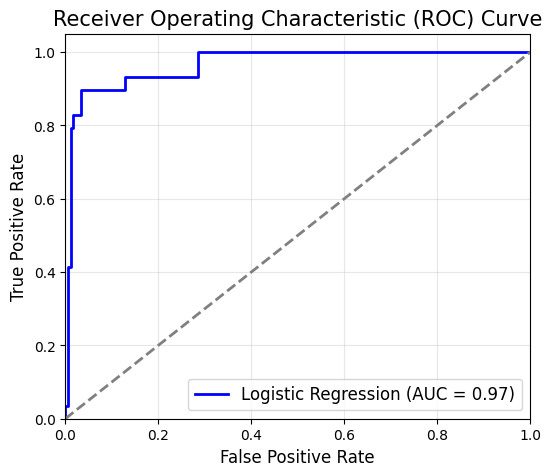

In [86]:
# Plot ROC AUC curve
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_val_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(6, 5))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

* Observation on CV:
  * Precision: Model is 79% of the time correct to predicts security-related. Can be improved.
  * Recall: Model captured 66% of the security-related, there is room for improvement. Consider LLM misclassification few security-related messages might have been missed.
  * F1: Balance between precision & recall is 72%.

* Observation on Validation:
  * Precision: Model is 92% of the time correct to predicts security-related.
  * Recall: Model captured 76% of the security-related, there is room for improvement. Consider LLM misclassification few security-related messages might have been missed and this can be further improved.
  * F1: Balance between precision & recall is 83%.
  
* Conclusion:
  * Since these are security related messages, the focus is usually on recall but LLMs could have introduced biases or errors in labelling thus focusing on just recall is not ideal. So, will be using optimising the model for the other metrics as well including precision & f1-score
  * LLM label influence: Considering this scenario, we trade off few false positives and increase recall.

**Step 5.1.2: XGBoost Modelling**

In [87]:
# Calculate scale_pos_weight
negative_count = sum(y_train == 0)
positive_count = sum(y_train == 1)
scale_pos_weight = negative_count / positive_count
print(scale_pos_weight)

4.187096774193549


In [88]:
# XGBClassifier
xgb_clf = xgb.XGBClassifier(
            eval_metric = 'logloss',
            random_state = seed,
            scale_pos_weight=scale_pos_weight
)

# Print the default parameters
# print(xgb_clf.get_params())

Logloss metric penalizes models particularly beneficial in imbalanced data & noisy labels.

Also, scale_pos_weight adjusts class imbalance in XGBoost by assigning higher weights to the minority class, improving model focus on correctly predicting it.

In [89]:
# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Get cross-validated predictions
y_pred_cv = cross_val_predict(xgb_clf, X_train_embs, y_train, cv=cv)

# Classification report
print("Cross-validated classification report:")
print(classification_report(y_train, y_pred_cv))

# Calculate ROC AUC score
roc_auc_cv = roc_auc_score(y_train, y_pred_cv)
print(f"Cross-validated ROC AUC score: {roc_auc_cv:.4f}")

Cross-validated classification report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       649
           1       0.82      0.59      0.68       155

    accuracy                           0.90       804
   macro avg       0.86      0.78      0.81       804
weighted avg       0.89      0.90      0.89       804

Cross-validated ROC AUC score: 0.7781


In [90]:
xgb_clf.fit(X_train_embs, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [91]:
# Predict on validation data
y_val_pred_xgb = xgb_clf.predict(X_val_embs)
y_val_proba_xgb = xgb_clf.predict_proba(X_val_embs)[:, 1]

In [92]:
# Calculate evaluation metrics
roc_auc_xgb = roc_auc_score(y_val, y_val_proba_xgb)
precision_xgb, recall_xgb, f1_xgb, _ = precision_recall_fscore_support(y_val, y_val_pred_xgb, average='binary')

print(f"Validation Precision: {precision_xgb}")
print(f"Validation Recall: {recall_xgb}")
print(f"Validation F1 Score: {f1_xgb}")
print(f"Validation ROC AUC: {roc_auc_xgb}")

# Print classification report
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred_xgb))

Validation Precision: 0.8181818181818182
Validation Recall: 0.6206896551724138
Validation F1 Score: 0.7058823529411765
Validation ROC AUC: 0.9520850040096231
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       172
           1       0.82      0.62      0.71        29

    accuracy                           0.93       201
   macro avg       0.88      0.80      0.83       201
weighted avg       0.92      0.93      0.92       201



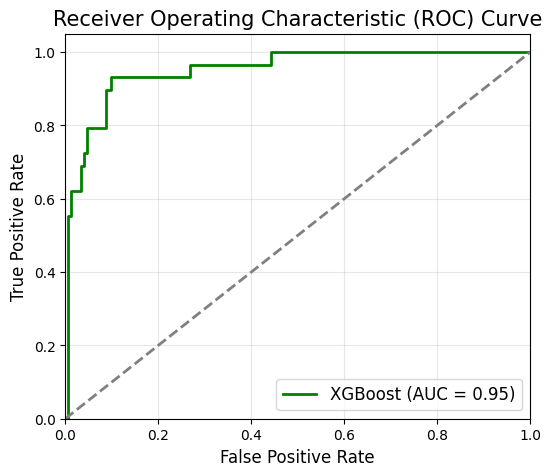

In [93]:
# Plot ROC AUC curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, y_val_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(6, 5))
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

* Observation on CV:
  * Precison: Model is 82% of the time correct to predict security-related. Good & can be improved.
  * Recall: Model captures only 59% of security-related. Room for improvement & considering incorrect labels from LLM we may be missing few security-related messages.
  * F1: Moderate performance 68%. Can be improved

* Observation on Validation:
  * Precision: Model is 82% of the time correct to predicts security-related. Consistent with cv results
  * Recall: Model captured only 62% of the security related, room for improvment
  * F1: Balance between precision & recall is 71%. Can be improved

**Step 5.2: SMOTE Implementation**

Data imbalance is a common issue in machine learning where one class of data is significantly more prevalent than another. This can lead models to be biased towards the majority class, resulting in poorer performance for the minority class.

Implementing SMOTE oversampling technique to balance the dataset. This technique improves model performance by ensuring it learns from a more representative sample, enhancing its ability to generalize and make accurate predictions across all classes.

**Step 5.2.1: LR with SMOTE**

In [94]:
# Define Logistic Regression model
lr_model = LogisticRegression(random_state=seed)

# Cross-validation with StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
y_pred_proba_lr = cross_val_predict(lr_model, X_train_resampled, y_train_resampled, cv=cv, method='predict_proba')[:, 1]

# Adjust threshold
optimal_threshold_lr = 0.3
y_pred_adjusted_lr = (y_pred_proba_lr >= optimal_threshold_lr).astype(int)

# Evaluate
print("Logistic Regression with SMOTE")
print(classification_report(y_train_resampled, (y_pred_proba_lr > 0.5).astype(int)))
print(f"Cross-validated ROC AUC score: {roc_auc_score(y_train_resampled, y_pred_proba_lr)}")

# Fit on full training data and evaluate on validation set
lr_model.fit(X_train_resampled, y_train_resampled)
y_val_pred_proba_lr = lr_model.predict_proba(X_val_embs)[:, 1]

print("Validation Performance for Logistic Regression")
print(classification_report(y_val, (y_val_pred_proba_lr > 0.5).astype(int)))
print(f"Validation ROC AUC score: {roc_auc_score(y_val, y_val_pred_proba_lr)}")

Logistic Regression with SMOTE
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       649
           1       0.92      0.94      0.93       649

    accuracy                           0.93      1298
   macro avg       0.93      0.93      0.93      1298
weighted avg       0.93      0.93      0.93      1298

Cross-validated ROC AUC score: 0.9763295908604206
Validation Performance for Logistic Regression
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       172
           1       0.80      0.83      0.81        29

    accuracy                           0.95       201
   macro avg       0.89      0.90      0.89       201
weighted avg       0.95      0.95      0.95       201

Validation ROC AUC score: 0.9558941459502805


* Observation:
  * Upsampling is overfitting, will not consider this option for logistic regression

**Step 5.2.2: XGBClassifier with SMOTE & CV**

In [95]:
# XGBClassifier
xgb_clf_smote = xgb.XGBClassifier(
            eval_metric = 'logloss',
            random_state = seed,
            scale_pos_weight=scale_pos_weight
)

In [96]:
# Create a pipeline
xgb_pipeline = Pipeline([('smote', smote),
                     ('classifier', xgb_clf_smote)])

In [97]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [98]:
# Perform cross-validation and get predictions
y_pred_cv = cross_val_predict(xgb_pipeline, X_train_embs, y_train, cv=cv, method='predict')
y_pred_proba_cv = cross_val_predict(xgb_pipeline, X_train_embs, y_train, cv=cv, method='predict_proba')[:, 1]

# Calculate ROC AUC score for cross-validation predictions
roc_auc_cv = roc_auc_score(y_train, y_pred_proba_cv)
print(f"Cross-Validation ROC AUC score: {roc_auc_cv:.4f}")

# Print classification report for cross-validation predictions
print("Cross-Validation Classification Report:")
print(classification_report(y_train, y_pred_cv))

Cross-Validation ROC AUC score: 0.9120
Cross-Validation Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       649
           1       0.72      0.66      0.69       155

    accuracy                           0.88       804
   macro avg       0.82      0.80      0.81       804
weighted avg       0.88      0.88      0.88       804



In [99]:
# Fit pipeline on entire train
xgb_pipeline.fit(X_train_embs, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [100]:
# Predict on validation data
y_val_pred_xgb_smote = xgb_pipeline.predict(X_val_embs)
y_val_proba_xgb_smote = xgb_pipeline.predict_proba(X_val_embs)[:, 1]

In [101]:
# Calculate evaluation metrics
roc_auc_xgb_smote = roc_auc_score(y_val, y_val_proba_xgb_smote)
precision_xgb_smote, recall_xgb_smote, f1_xgb_smote, _ = precision_recall_fscore_support(y_val, y_val_pred_xgb_smote, average='binary')

print(f"Validation Precision: {precision_xgb_smote}")
print(f"Validation Recall: {recall_xgb_smote}")
print(f"Validation F1 Score: {f1_xgb_smote}")
print(f"Validation ROC AUC: {roc_auc_xgb_smote}")

# Print classification report
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred_xgb_smote))

Validation Precision: 0.8148148148148148
Validation Recall: 0.7586206896551724
Validation F1 Score: 0.7857142857142857
Validation ROC AUC: 0.9637129109863672
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       172
           1       0.81      0.76      0.79        29

    accuracy                           0.94       201
   macro avg       0.89      0.86      0.88       201
weighted avg       0.94      0.94      0.94       201



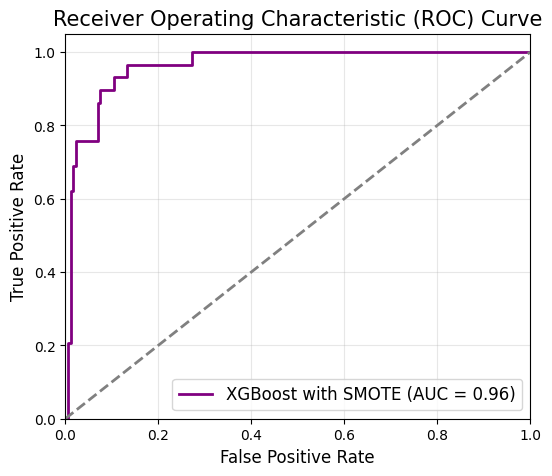

In [102]:
# Plot ROC AUC curve
fpr_xgb_smote, tpr_xgb_smote, _ = roc_curve(y_val, y_val_proba_xgb_smote)
roc_auc_xgb_smote = auc(fpr_xgb_smote, tpr_xgb_smote)

plt.figure(figsize=(6, 5))
plt.plot(fpr_xgb_smote, tpr_xgb_smote, color='purple', lw=2, label=f'XGBoost with SMOTE (AUC = {roc_auc_xgb_smote:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

* Observation on CV:
  * Precison: Model is 72% of the time correct to predict security-related. Good & can be improved.
  * Recall: Model captures only 66% of security-related. Room for improvement & considering incorrect labels from LLM we may be missing few security-related messages.
  * F1: Moderate performance 69%. Can be improved

* Observation on Validation:
  * Precision: Model is 81% of the time correct to predicts security-related. Consistent with cv results
  * Recall: Model captured only 76% of the security related, room for improvment
  * F1: Balance between precision & recall is 79%. Can be improved

* Conclusion:
  * Upsampling does increase the recall but since precision decreased we are introducing false positives.
  * LLMs might have missed few security related messages during labelling. We balance that with this trade off and capture as many security messages as possible.

**Step 5.2.3: Hyperparameter Tuning**

In [103]:
# XGBoost model
xgb_tune_clf = XGBClassifier(eval_metric='logloss', random_state=seed, scale_pos_weight=scale_pos_weight)

In [104]:
xgb_tune_pipeline = Pipeline([('smote', smote),
                              ('classifier', xgb_tune_clf)])

In [105]:
# Parameter grid
param_grid = {
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__max_depth': [3, 4, 5],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'smote__sampling_strategy': ['auto', 0.3, 0.5]  # Adjusted sampling strategies for SMOTE
}


In [106]:
# Cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [107]:
# Grid Search CV
grid_search = GridSearchCV(estimator=xgb_tune_clf, param_grid=param_grid, cv=cv, scoring='roc_auc', verbose=1, n_jobs=-1)

In [108]:
# Model save path
model_file_path = 'best_xgboost_model.pkl'

# Grid search fit to find best hyperparameters
# grid_search.fit(X_train_embs, y_train)
# print(grid_search.best_params_)
# print(grid_search.best_score_)

# Best model
# xgb_tune_model = grid_search.best_estimator_

# Save the best model to disk
# joblib.dump(xgb_tune_model, model_file_path)

# Optionally, you can also save the grid search object itself for later reference
# grid_search_file_path = 'grid_search_object.pkl'
# joblib.dump(param_grid, grid_search_file_path)

In [109]:
# Load the saved model from disk
xgb_tune_model = joblib.load(model_file_path)

In [110]:
# Using cross_val_predict
y_pred_tune_cv = cross_val_predict(xgb_tune_model, X_train_embs, y_train, cv=cv, method='predict')
y_pred_tune_proba_cv = cross_val_predict(xgb_tune_model, X_train_embs, y_train, cv=cv, method='predict_proba')[:, 1]

# Calculate ROC AUC score for cross-validation predictions
roc_auc_tune_cv = roc_auc_score(y_train, y_pred_tune_proba_cv)
print(f"Cross-Validation ROC AUC score: {roc_auc_tune_cv:.4f}")

# Print classification report for cross-validation predictions
print("Cross-Validation Classification Report:")
print(classification_report(y_train, y_pred_tune_cv))

Cross-Validation ROC AUC score: 0.9084
Cross-Validation Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       649
           1       0.82      0.59      0.68       155

    accuracy                           0.90       804
   macro avg       0.86      0.78      0.81       804
weighted avg       0.89      0.90      0.89       804



In [111]:
# Predict on validation data
y_val_tune_pred = xgb_tune_model.predict(X_val_embs)
y_val_tune_proba = xgb_tune_model.predict_proba(X_val_embs)[:, 1]

# Calculate evaluation metrics
roc_auc = roc_auc_score(y_val, y_val_tune_proba)
precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_tune_pred, average='binary')

print(f"Validation Precision: {precision}")
print(f"Validation Recall: {recall}")
print(f"Validation F1 Score: {f1}")
print(f"Validation ROC AUC: {roc_auc}")

# Print classification report
print("Validation Classification Report:")
print(classification_report(y_val, y_val_tune_pred))

Validation Precision: 0.8181818181818182
Validation Recall: 0.6206896551724138
Validation F1 Score: 0.7058823529411765
Validation ROC AUC: 0.9520850040096231
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       172
           1       0.82      0.62      0.71        29

    accuracy                           0.93       201
   macro avg       0.88      0.80      0.83       201
weighted avg       0.92      0.93      0.92       201



In [112]:
# Example results for logistic regression and XGBoost
results = {
    'Model': ['Logistic Regression', 'XGBoost', 'XGBoost with SMOTE'],
    'Precision': [0.92, 0.82, 0.81],
    'Recall': [0.76, 0.62, 0.76],
    'F1 Score': [0.83, 0.71, 0.79],
    'ROC AUC': [0.97, 0.95, 0.96]
}

# Convert to DataFrame
df_results = pd.DataFrame(results)

In [113]:
# Calculate error ratio
lr_score = results['F1 Score'][0]
xgb_smote_score = results['F1 Score'][2]

error_ratio = (1 - lr_score) / (1 - xgb_smote_score)

print(f"Error Ratio for F1 Score: {error_ratio:.2f}")

Error Ratio for F1 Score: 0.81


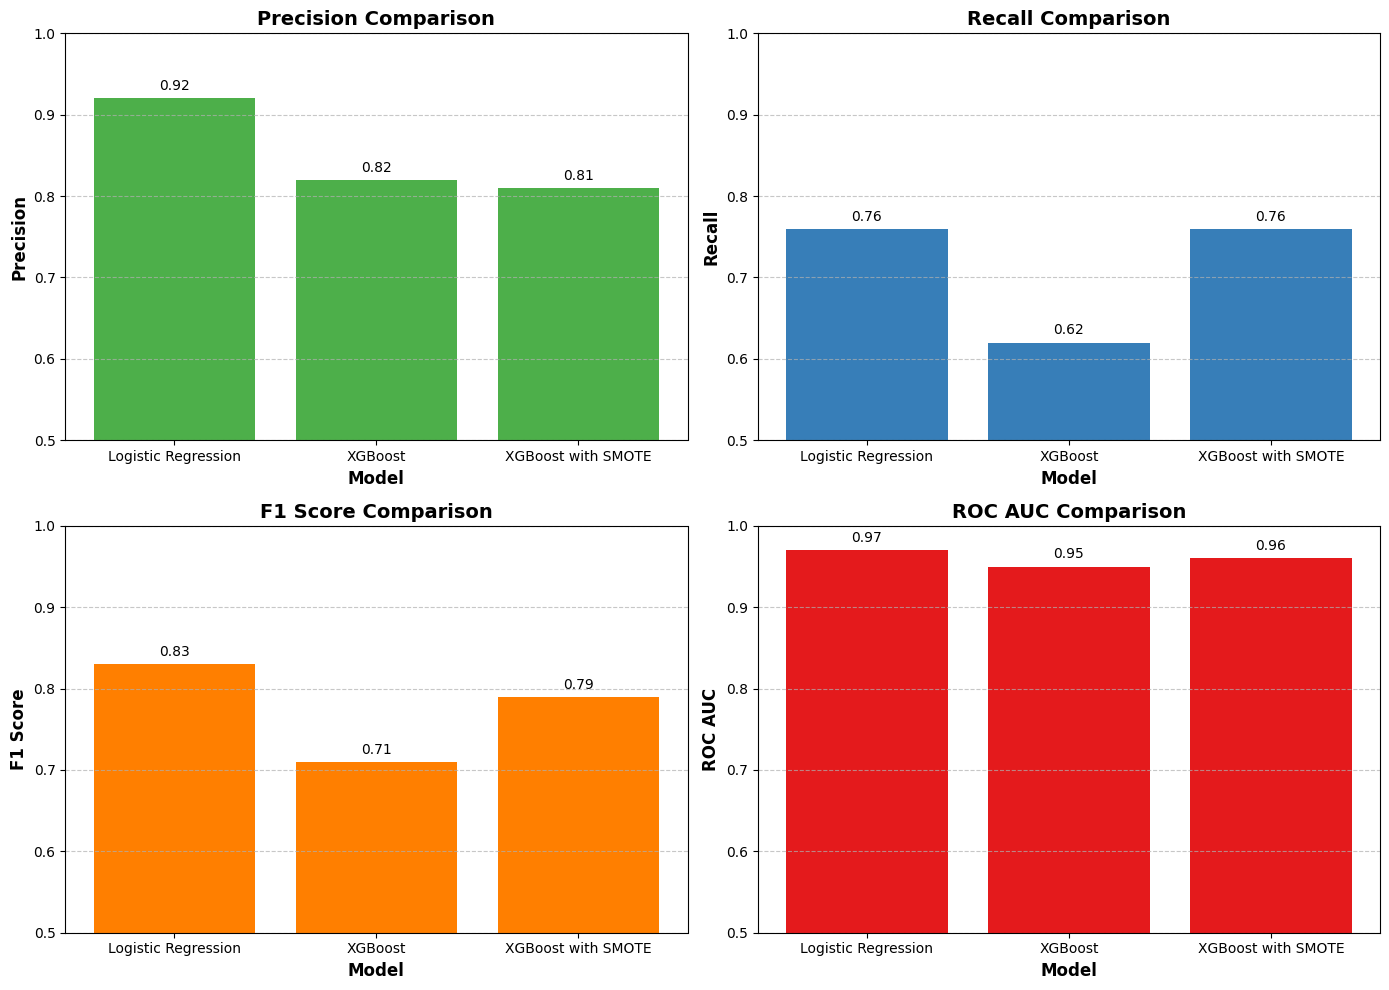

In [114]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Precision', 'Recall', 'F1 Score', 'ROC AUC']
colors = ['#4daf4a', '#377eb8', '#ff7f00', '#e41a1c']
titles = ['Precision Comparison', 'Recall Comparison', 'F1 Score Comparison', 'ROC AUC Comparison']

for ax, metric, color, title in zip(axes.flatten(), metrics, colors, titles):
    ax.bar(df_results['Model'], df_results[metric], color=color)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylim(0.5, 1)
    ax.set_xlabel('Model', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    for i in range(len(df_results)):
        ax.text(i, df_results[metric][i] + 0.01, f'{df_results[metric][i]:.2f}', ha='center', fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


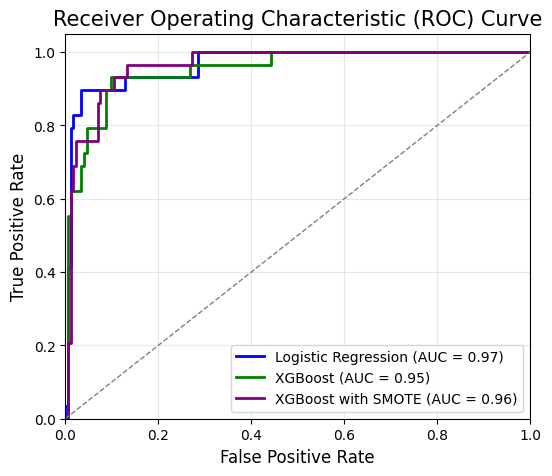

In [115]:
# Plotting all ROC AUC curves together
plt.figure(figsize=(6, 5))

# Logistic Regression ROC AUC curve
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')

# XGBoost ROC AUC curve
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')

# XGBoost with SMOTE ROC AUC curve
plt.plot(fpr_xgb_smote, tpr_xgb_smote, color='purple', lw=2, label=f'XGBoost with SMOTE (AUC = {roc_auc_xgb_smote:.2f})')

# Plot diagonal line (baseline)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)

plt.show()

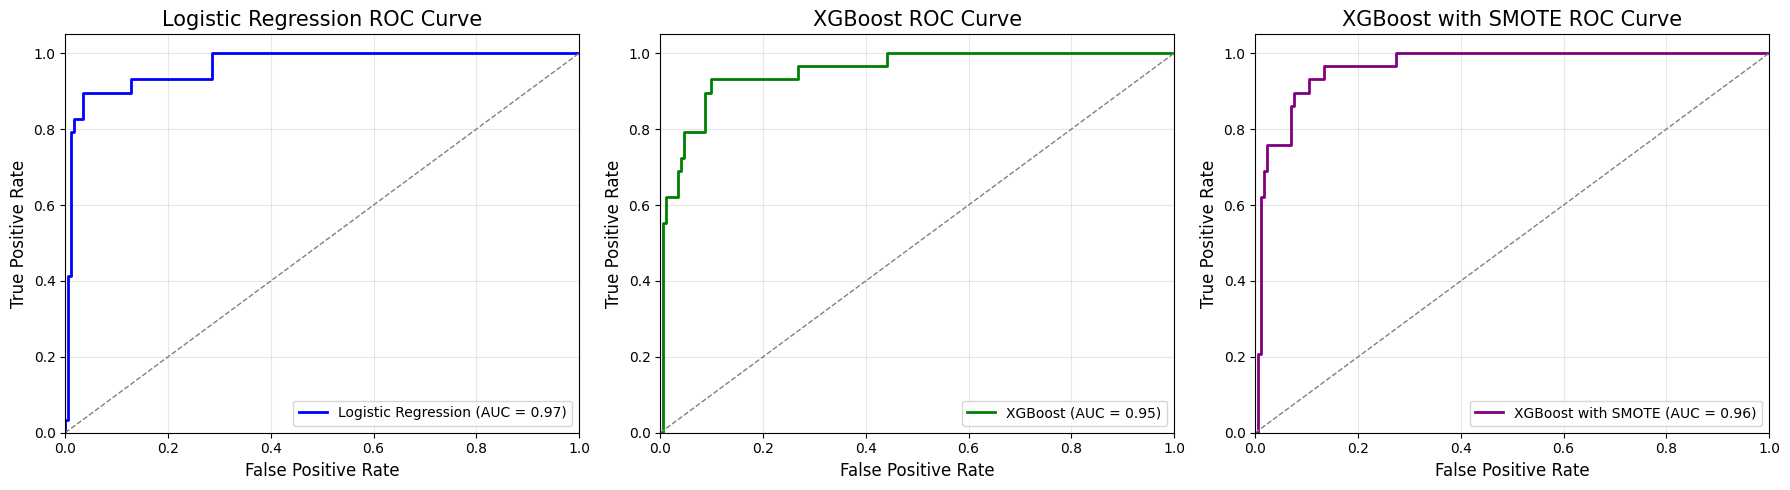

In [116]:
# Plotting ROC AUC curves in a grid layout
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Logistic Regression ROC AUC curve
axes[0].plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
axes[0].plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('Logistic Regression ROC Curve', fontsize=15)
axes[0].legend(loc="lower right", fontsize=10)
axes[0].grid(alpha=0.3)

# XGBoost ROC AUC curve
axes[1].plot(fpr_xgb, tpr_xgb, color='green', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
axes[1].plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('XGBoost ROC Curve', fontsize=15)
axes[1].legend(loc="lower right", fontsize=10)
axes[1].grid(alpha=0.3)

# XGBoost with SMOTE ROC AUC curve
axes[2].plot(fpr_xgb_smote, tpr_xgb_smote, color='purple', lw=2, label=f'XGBoost with SMOTE (AUC = {roc_auc_xgb_smote:.2f})')
axes[2].plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('False Positive Rate', fontsize=12)
axes[2].set_ylabel('True Positive Rate', fontsize=12)
axes[2].set_title('XGBoost with SMOTE ROC Curve', fontsize=15)
axes[2].legend(loc="lower right", fontsize=10)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Conclusion:**

Based on the analysis:

**Best Model**

* **Logistic Regression without SMOTE** shows consistently high performance, with robust precision and recall, particularly on the validation set. This model achieves the best balance of precision, recall, F1 score, and ROC AUC, making it the most reliable choice despite potential label noise.

* **XGBoost with SMOTE** improves recall but at the cost of precision. While it performs well in terms of ROC AUC, the trade-off between precision and recall is less favorable compared to Logistic Regression.

* **Error rate:** Also, considering the error rate Logistic Regression performs approximately 19% better than XGBoost with SMOTE in terms of F1 score

* **Best Model:** Thus, Logistic Regression without SMOTE is recommended as the best model. It provides strong and consistent performance across metrics, and its higher precision and recall on the validation set indicate it can handle noisy labels effectively. The focus on precision and the trade-off with recall is justifiable in this context, ensuring a good balance between correctly identified security messages and manageable false positives.

**Handling LLM Bias**

- **Proposed**: Adjusting the decision threshold can improve the handling of mis-labelling by focusing on increasing recall, thereby capturing more security messages.

**Conclusion:** Logistic Regression is generally more robust to mislabeled data compared to its simplicity and regularization. It's less prone to overfitting and more resistant to noise. Regularization further helps by penalizing complex models, thus maintaining simplicity and stability. XGBoost, being a complex ensemble method, can overfit noisy data more easily, leading to poorer generalization. Therefore, LR's higher recall and F1 scores suggest it handles the potential mislabeling by an LLM better than XGBoost.

**Step 6: Prompt Optimization**

**1. Initial Prompt Definition**
- Define the initial prompt to be used by the LLM for labeling data.

**2. Persona Integration**
- Integrate a detailed persona to guide the LLM's perspective and enhance context understanding and consistency.

**3. Example Inclusion**
- Provide clear examples to illustrate security-related vs non security-related messages

Improved Prompt Example:

```
You are a workplace safety and security officer with expertise in ensuring the physical and digital safety of employees. You have a keen eye for identifying potential risks and are well-versed in safety protocols, emergency responses, and security measures.

You will be given a workplace recognition or gratitude message between colleagues. Determine if the message is related to safety or security based on the content. A message is related to safety or security if it describes actions or situations that pertain to the physical or digital protection of people, information, or property.

Examples of messages related to safety or security (return "True"):

"Mary went above and beyond her own personal comfort zone in assisting in a safety incident in the lab. She printed MS sheets and made the situation safe for both me and her colleagues in the area. She also was an amazing, calming influence on a high stress situation."
"Lisa - thanks for taking the time to double check a suspicious contact that came in to you this week - although we were able to verify the message after a bit of digging it was certainly VERY odd looking and certainly worth a second look. You demonstrated fantastic security reflexes!"
Examples of messages not related to safety or security (return "False"):

"John did an excellent job presenting our quarterly results to the board. His thorough analysis and clear communication were greatly appreciated by everyone."
"Thank you, Sarah, for organizing the team lunch. It was a great opportunity for us to bond and enjoy some time away from work."
Return "True" if the message is related to safety or security, and "False" otherwise.

```

**4. Validation Set Creation**
- Create a validation set to test the prompt effectively, including historic security messages if available

**5. Initial Testing and Metrics Calculation**
- Run the initial prompt on the validation set and calculate performance metrics focusing on recall while balancing precision.

**6. Evaluate Different Prompts**
- Analyze misclassifications to identify common patterns and issues in the LLM's predictions.
- Adjust the prompt based on insights gained from error analysis.

**7. Compare Performance**
- Compare performance metrics (especially recall, precision, and F1 score) across different prompt versions.

**8. Select Optimal Prompt**
- Choose the prompt version that yields the best performance based on evaluation metrics.

**9. Threshold Adjustment**
- Adjust the decision threshold on the LLM's output probabilities to optimize for recall while maintaining acceptable precision.

**10. Final Evaluation**
- Evaluate the final prompt configuration and threshold adjustment on the validation set to ensure it meets performance goals.


